# Tutorial 03: Advanced Sky Mapping Visualization

This tutorial explores advanced visualization techniques for radio astronomy observations. It covers:

1. Creating power maps of the entire sky
2. Comparing scenarios with and without satellite interference
3. Visualizing satellite positions on sky maps
4. Analyzing interference patterns across the sky
5. Creating difference maps to highlight interference effects

## Learning Objectives:
- Understand sky mapping techniques for radio astronomy
- Learn to visualize interference patterns across the entire sky
- Explore advanced plotting techniques with polar projections
- Analyze the spatial distribution of satellite interference
- Compare different observation scenarios using sky maps

## Prerequisites:
- Completion of Tutorial 01: Basic Radio Astronomy Observation
- Completion of Tutorial 02: Satellite Interference Analysis
- Understanding of coordinate systems and sky projections

## Output Files:
- `03_sky_map_no_satellites.png`: Sky map without satellite interference
- `03_sky_map_with_satellites.png`: Sky map with satellite interference
- `03_interference_difference_map.png`: Difference map showing interference effects
- `03_sky_maps_comparison.png`: Side-by-side comparison of both scenarios


## Import Required Libraries

First, let's import the necessary libraries and set up the Python path to access the RSC-SIM modules.


In [1]:
import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Add the src directory to the Python path
sys.path.insert(0, '/Users/lkruczek/Documents/SpectrumX/github/flagship2/RSC-SIM/src')

# Add the modular_tutorials directory to the Python path
sys.path.insert(0, '/Users/lkruczek/Documents/SpectrumX/github/flagship2/RSC-SIM/modular_tutorials')

from radio_types import Trajectory, Observation, Constellation
from obs_mdl import model_observed_temp
from astro_mdl import temperature_to_power

# Import shared utilities
from shared import (
    setup_westford_telescope,
    setup_satellite_transmitter,
    create_sky_model,
    setup_plotting,
    OBSERVATION_START,
    OBSERVATION_END,
    BANDWIDTH,
    STARLINK_TRAJECTORY_FILE,
    AZIMUTH_GRID_STEP,
    ELEVATION_GRID_STEP
)

# Import satellite modeling functions
from sat_mdl import sat_link_budget_vectorized

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


## Define Helper Functions

We'll define several helper functions for sky mapping and visualization.


In [2]:
def lnk_bdgt(*args, **kwargs):
    """
    Link budget wrapper function that handles beam avoidance parameters.
    """
    # Remove beam_avoid parameter if present
    kwargs.pop('beam_avoid', None)

    # Call the vectorized link budget function
    return sat_link_budget_vectorized(*args, **kwargs)


def create_sky_grid(azimuth_step=5, elevation_step=1):
    """
    Create a sky grid for mapping.

    Args:
        azimuth_step: Step size for azimuth angles (degrees)
        elevation_step: Step size for elevation angles (degrees)

    Returns:
        tuple: (azimuth_grid, elevation_grid, n_az, n_el)
    """
    azimuth_grid = np.arange(0, 356, azimuth_step)
    elevation_grid = np.arange(0, 91, elevation_step)
    n_az = len(azimuth_grid)
    n_el = len(elevation_grid)

    return azimuth_grid, elevation_grid, n_az, n_el


def compute_sky_map(time_plot, telescope, sky_model, constellation=None,
                    azimuth_step=5, elevation_step=1):
    """
    Compute a sky map for a specific time.

    Args:
        time_plot: Time to compute the map for
        telescope: Telescope instrument
        sky_model: Sky temperature model function
        constellation: Optional satellite constellation
        azimuth_step: Step size for azimuth angles (degrees)
        elevation_step: Step size for elevation angles (degrees)

    Returns:
        array: 2D array of power values (elevation x azimuth)
    """
    # Create sky grid
    azimuth_grid, elevation_grid, n_az, n_el = create_sky_grid(azimuth_step, elevation_step)

    # Prepare output array
    map_grid = np.zeros((n_el, n_az))

    print(f"Computing sky map for {time_plot}...")
    print(f"Grid size: {n_el} x {n_az} = {n_el * n_az} points")

    start_time = time.time()

    # Loop over the grid
    for i, el in enumerate(elevation_grid):
        for j, az in enumerate(azimuth_grid):
            # Create trajectory for this point
            point_df = pd.DataFrame({
                'times': [time_plot],
                'azimuths': [az],
                'elevations': [el],
                'distances': [np.inf]
            })
            traj = Trajectory(point_df)

            # Create observation for this point
            obs = Observation.from_dates(time_plot, time_plot, traj, telescope)

            # Compute observed temperature
            if constellation is not None:
                result = model_observed_temp(obs, sky_model, constellation)
            else:
                result = model_observed_temp(obs, sky_model)

            map_grid[i, j] = result[0, 0, 0]

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Sky map computation completed in {execution_time:.2f} seconds")

    return map_grid, azimuth_grid, elevation_grid


def plot_sky_map(map_grid, azimuth_grid, elevation_grid, title="Sky Map",
                 constellation=None, source_trajectory=None, time_plot=None,
                 colormap="plasma", figsize=(16, 16)):
    """
    Plot a sky map with optional satellite and source positions.

    Args:
        map_grid: 2D array of power values
        azimuth_grid: Azimuth angle grid
        elevation_grid: Elevation angle grid
        title: Plot title
        constellation: Optional satellite constellation for plotting positions
        source_trajectory: Optional source trajectory for plotting position
        time_plot: Time for plotting satellite/source positions
        colormap: Color map for the plot
        figsize: Figure size

    Returns:
        tuple: (figure, axes) objects
    """
    # Convert temperature to power
    power_grid = temperature_to_power(map_grid, BANDWIDTH)

    # Create polar plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1, polar=True)

    # Plot the sky map
    pc = ax.pcolormesh(
        np.radians(azimuth_grid),
        90 - elevation_grid,
        10 * np.log10(power_grid),
        cmap=colormap
    )

    # Add colorbar
    cbar = plt.colorbar(pc)
    cbar.set_label("Power [dBW]")

    # Plot satellite positions if provided
    if constellation is not None and time_plot is not None:
        sats_at_t = constellation.get_sats_names_at_time(time_plot)
        sel_sats = sats_at_t[:len(sats_at_t)]
        for s in sel_sats:
            sat = constellation.get_sat_traj(s)
            sat_pt = sat[sat['times'] == time_plot]
            ax.scatter(np.radians(sat_pt['azimuths']),
                       90 - sat_pt['elevations'],
                       c='red', s=20, alpha=0.7, label='Satellites' if s == sel_sats[0] else "")

    # Plot source position if provided
    if source_trajectory is not None and time_plot is not None:
        src_pt = source_trajectory.get_traj()[source_trajectory.get_traj()['times'] == time_plot]
        if len(src_pt) > 0:
            ax.scatter(np.radians(src_pt['azimuths']),
                       90 - src_pt['elevations'],
                       marker="*", c="yellow", s=100, label="Cas A")

    # Set up axis formatting
    ax.set_yticks(range(0, 91, 10))
    ax.set_yticklabels([str(x) for x in range(90, -1, -10)])
    ax.set_theta_zero_location("N")
    ax.set_title(title)

    # Add legend if we have satellite or source positions
    if (constellation is not None or source_trajectory is not None) and time_plot is not None:
        ax.legend()

    return fig, ax


def plot_difference_map(map_with_satellites, map_without_satellites,
                        azimuth_grid, elevation_grid, title="Interference Difference Map"):
    """
    Plot the difference between maps with and without satellites.

    Args:
        map_with_satellites: Sky map with satellite interference
        map_without_satellites: Sky map without satellite interference
        azimuth_grid: Azimuth angle grid
        elevation_grid: Elevation angle grid
        title: Plot title

    Returns:
        tuple: (figure, axes) objects
    """
    # Convert to power
    power_with_sat = temperature_to_power(map_with_satellites, BANDWIDTH)
    power_without_sat = temperature_to_power(map_without_satellites, BANDWIDTH)

    # Compute difference in dB
    difference_db = 10 * np.log10(power_with_sat) - 10 * np.log10(power_without_sat)

    # Create polar plot
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(1, 1, 1, polar=True)

    # Plot the difference map
    pc = ax.pcolormesh(
        np.radians(azimuth_grid),
        90 - elevation_grid,
        difference_db,
        cmap="RdBu_r",
        vmin=-10,
        vmax=10
    )

    # Add colorbar
    cbar = plt.colorbar(pc)
    cbar.set_label("Power Difference [dB]")

    # Set up axis formatting
    ax.set_yticks(range(0, 91, 10))
    ax.set_yticklabels([str(x) for x in range(90, -1, -10)])
    ax.set_theta_zero_location("N")
    ax.set_title(title)

    return fig, ax

print("✓ Helper functions defined successfully")


✓ Helper functions defined successfully


## Step 1: Set Up the Telescope Instrument

We'll start by setting up our radio telescope instrument using the Westford telescope configuration.


In [3]:
# Set up plotting
setup_plotting()

print("Step 1: Setting up the Westford telescope instrument...")

telescope = setup_westford_telescope()
print("✓ Telescope instrument created")
print(f"  - Center frequency: {telescope.get_center_freq()/1e9:.3f} GHz")
print(f"  - Bandwidth: {telescope.get_bandwidth()/1e3:.1f} kHz")
print(f"  - Physical temperature: {telescope.get_phy_temp():.1f} K")


Step 1: Setting up the Westford telescope instrument...
This power_pattern_from_cut_file function assumes Daniel Sheen generated files
✓ Telescope instrument created
  - Center frequency: 11.325 GHz
  - Bandwidth: 1.0 kHz
  - Physical temperature: 300.0 K


## Step 2: Load Source Trajectory

Now we'll load the trajectory data for our astronomical source (Cas A - Cassiopeia A).


In [4]:
print("Step 2: Loading Cas A source trajectory...")

# Load source trajectory from file
source_trajectory = Trajectory.from_file(
    os.path.join(os.path.dirname(os.path.abspath('__file__')), "data",
                 "casA_trajectory_Westford_2025-02-18T15_00_00.000_2025-02-18T15_45_00.000.arrow"),
    time_tag='time_stamps',
    elevation_tag='altitudes',
    azimuth_tag='azimuths',
    distance_tag='distances'
)
print("✓ Source trajectory loaded")
print(f"  - Time range: {source_trajectory.get_traj()['times'].min()} to "
      f"{source_trajectory.get_traj()['times'].max()}")


Step 2: Loading Cas A source trajectory...
✓ Source trajectory loaded
  - Time range: 2025-02-18 15:00:00 to 2025-02-18 15:45:00


## Step 3: Set Up Satellite Constellation

We'll set up the satellite constellation to model interference effects.


In [5]:
print("Step 3: Setting up satellite constellation...")

# Create satellite transmitter
satellite_transmitter = setup_satellite_transmitter()
print("✓ Satellite transmitter created")

# Create a simple observation for constellation (needed for time bounds)
simple_obs = Observation.from_dates(
    OBSERVATION_START, OBSERVATION_END, source_trajectory, telescope
)

# Load satellite constellation
constellation = Constellation.from_file(
    STARLINK_TRAJECTORY_FILE,
    simple_obs,
    satellite_transmitter,
    lnk_bdgt,
    name_tag='sat',
    time_tag='timestamp',
    elevation_tag='elevations',
    azimuth_tag='azimuths',
    distance_tag='ranges_westford',
    filt_funcs=(('sat', lambda s: ~s.str.contains('DTC')), ('elevations', lambda e: e > 20.0))
)
print("✓ Satellite constellation loaded")
print(f"  - Number of satellites: {len(constellation.sats['sat'].unique())}")


Step 3: Setting up satellite constellation...
✓ Satellite transmitter created
✓ Satellite constellation loaded
  - Number of satellites: 201


## Step 4: Create Sky Model

We'll create the sky temperature model that includes all the components we want to observe.


In [6]:
print("Step 4: Creating sky temperature model...")

# Create a simple observation for sky model
simple_obs = Observation.from_dates(
    OBSERVATION_START, OBSERVATION_END, source_trajectory, telescope
)
sky_model = create_sky_model(simple_obs)
print("✓ Sky model created")


Step 4: Creating sky temperature model...
✓ Sky model created


## Step 5: Define Mapping Time and Grid

We'll set up the parameters for sky mapping, including the time and grid resolution.


In [7]:
print("Step 5: Setting up sky mapping parameters...")

# Define the time for sky mapping (same as original)
dateformat = "%Y-%m-%dT%H:%M:%S.%f"
time_plot = datetime.strptime("2025-02-18T15:34:29.000", dateformat)
print(f"  - Mapping time: {time_plot}")

# Create sky grid
azimuth_grid, elevation_grid, n_az, n_el = create_sky_grid(
    AZIMUTH_GRID_STEP, ELEVATION_GRID_STEP
)
print(f"  - Grid size: {n_el} x {n_az} = {n_el * n_az} points")
print(f"  - Azimuth range: {azimuth_grid[0]}° to {azimuth_grid[-1]}°")
print(f"  - Elevation range: {elevation_grid[0]}° to {elevation_grid[-1]}°")


Step 5: Setting up sky mapping parameters...
  - Mapping time: 2025-02-18 15:34:29
  - Grid size: 91 x 72 = 6552 points
  - Azimuth range: 0° to 355°
  - Elevation range: 0° to 90°


## Step 6: Compute Sky Map Without Satellites

We'll compute the baseline sky map without any satellite interference to establish our reference.


Step 6: Computing sky map without satellite interference...
Computing sky map for 2025-02-18 15:34:29...
Grid size: 91 x 72 = 6552 points
Sky map computation completed in 8.99 seconds


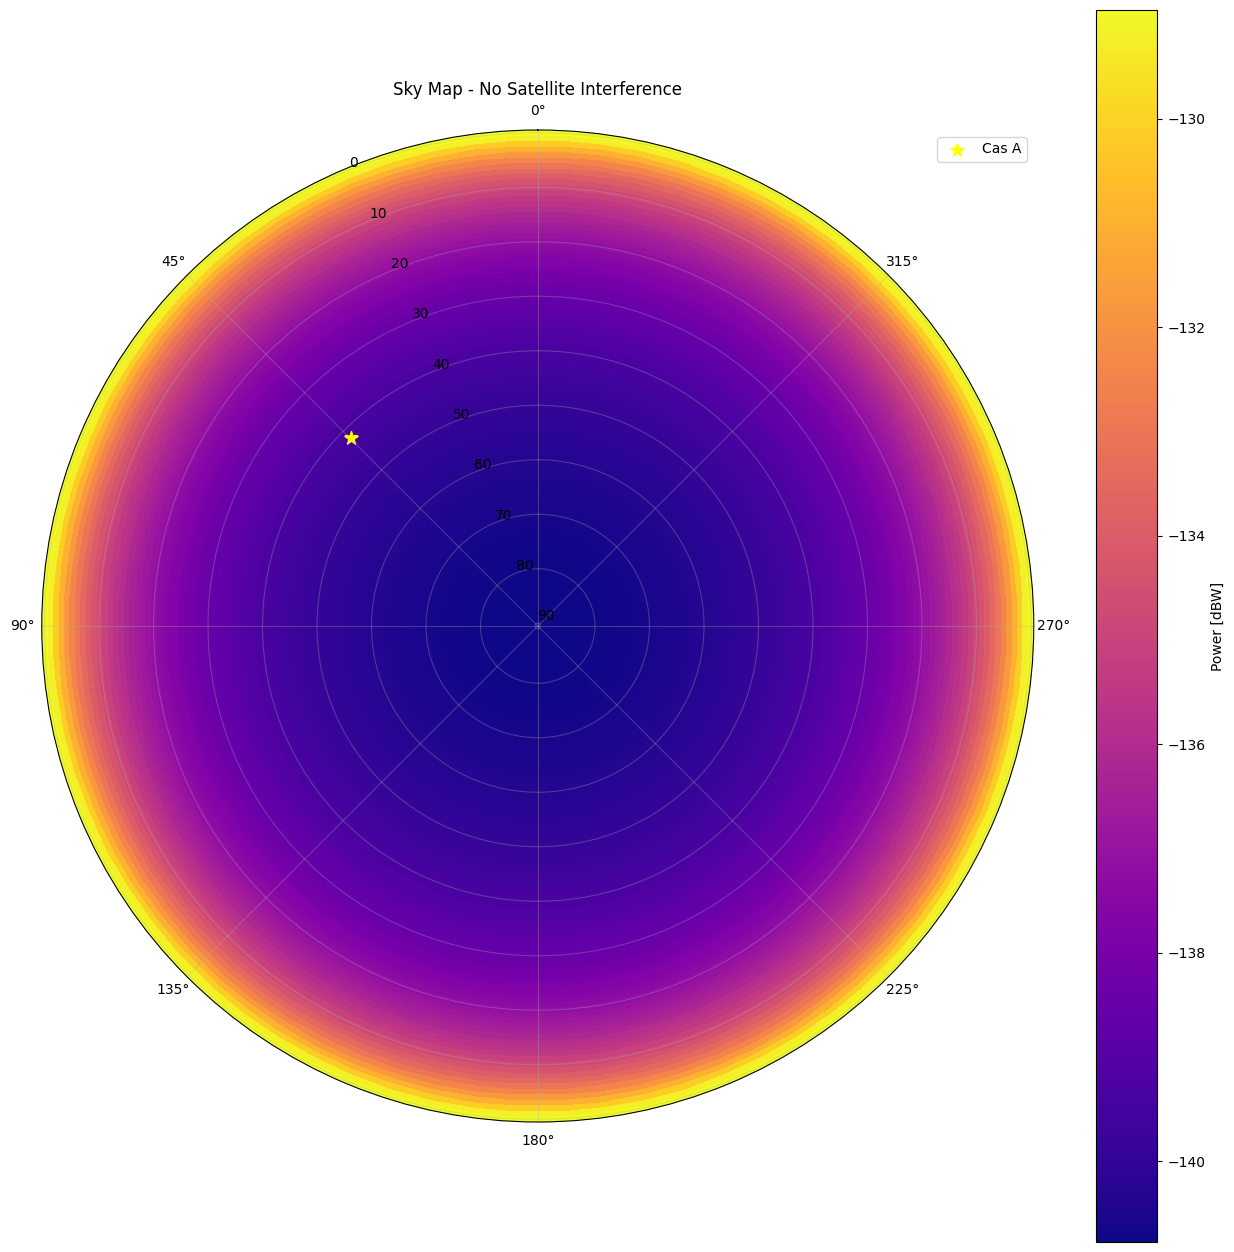

✓ Sky map without satellites saved as '03_sky_map_no_satellites.png'


In [8]:
print("Step 6: Computing sky map without satellite interference...")

map_without_satellites, azimuth_grid, elevation_grid = compute_sky_map(
    time_plot, telescope, sky_model, constellation=None,
    azimuth_step=AZIMUTH_GRID_STEP, elevation_step=ELEVATION_GRID_STEP
)

# Plot sky map without satellites
fig, ax = plot_sky_map(
    map_without_satellites, azimuth_grid, elevation_grid,
    title="Sky Map - No Satellite Interference",
    source_trajectory=source_trajectory, time_plot=time_plot,
    colormap="plasma"
)
plt.savefig('03_sky_map_no_satellites.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Sky map without satellites saved as '03_sky_map_no_satellites.png'")


## Step 7: Compute Sky Map With Satellites

Now we'll compute the sky map with satellite interference to see the impact of satellites.


Step 7: Computing sky map with satellite interference...
Computing sky map for 2025-02-18 15:34:29...
Grid size: 91 x 72 = 6552 points
Sky map computation completed in 20.69 seconds


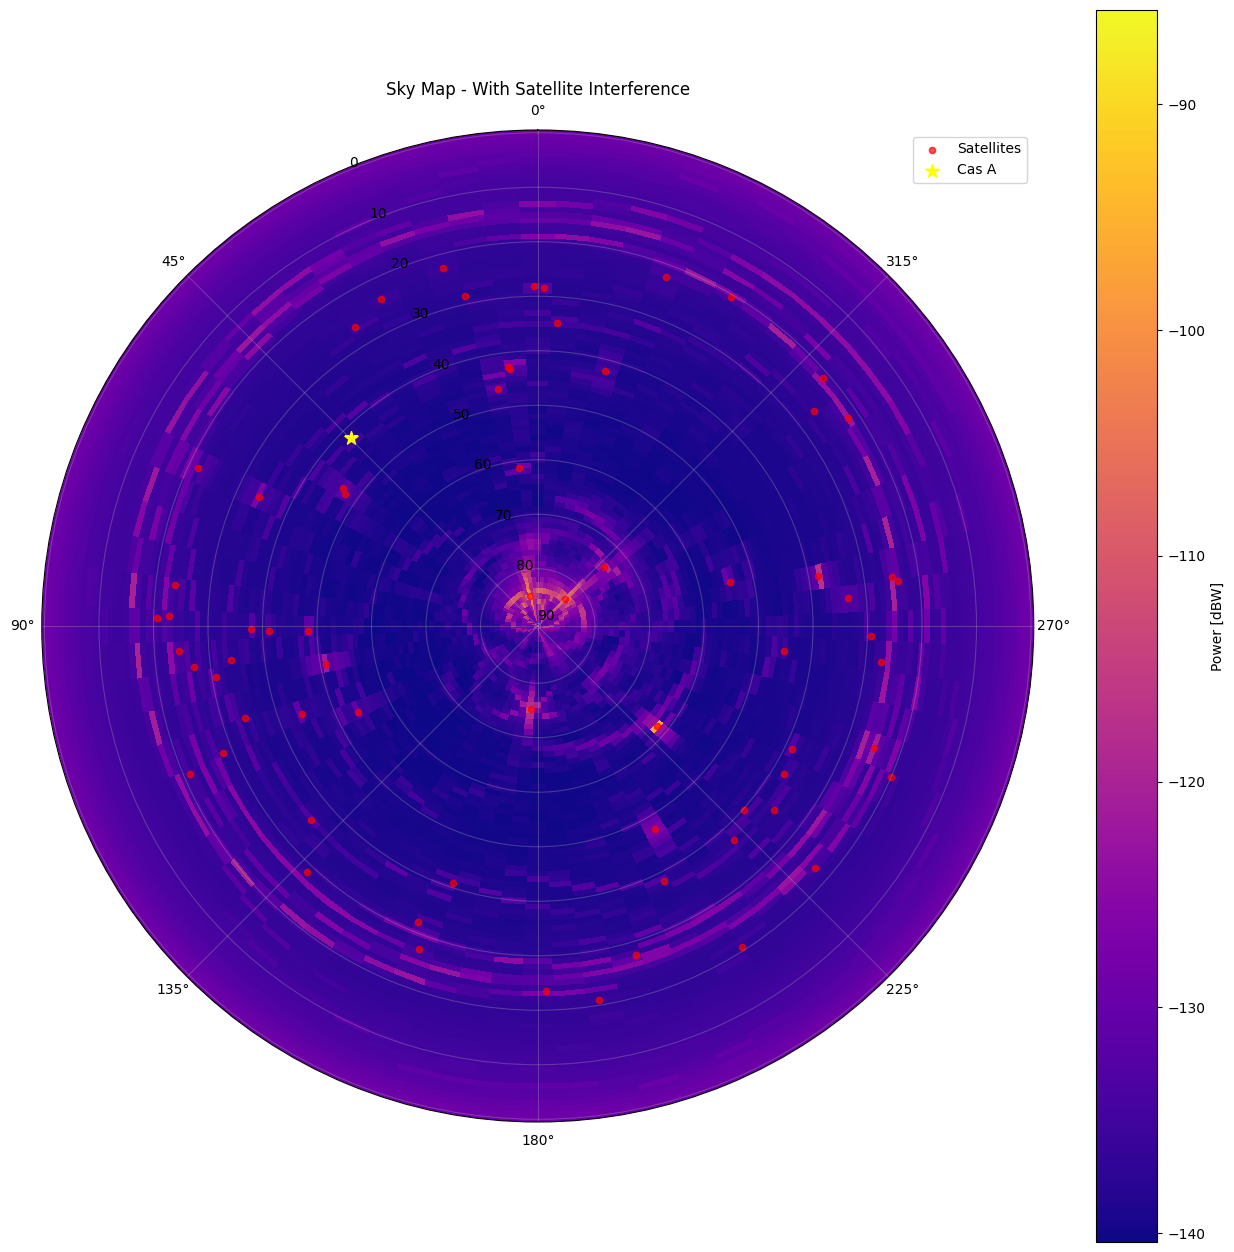

✓ Sky map with satellites saved as '03_sky_map_with_satellites.png'


In [9]:
print("Step 7: Computing sky map with satellite interference...")

map_with_satellites, azimuth_grid, elevation_grid = compute_sky_map(
    time_plot, telescope, sky_model, constellation=constellation,
    azimuth_step=AZIMUTH_GRID_STEP, elevation_step=ELEVATION_GRID_STEP
)

# Plot sky map with satellites
fig, ax = plot_sky_map(
    map_with_satellites, azimuth_grid, elevation_grid,
    title="Sky Map - With Satellite Interference",
    constellation=constellation, source_trajectory=source_trajectory,
    time_plot=time_plot, colormap="plasma"
)
plt.savefig('03_sky_map_with_satellites.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Sky map with satellites saved as '03_sky_map_with_satellites.png'")


## Step 8: Create Difference Map

We'll create a difference map to clearly highlight where satellite interference is occurring.


Step 8: Creating interference difference map...


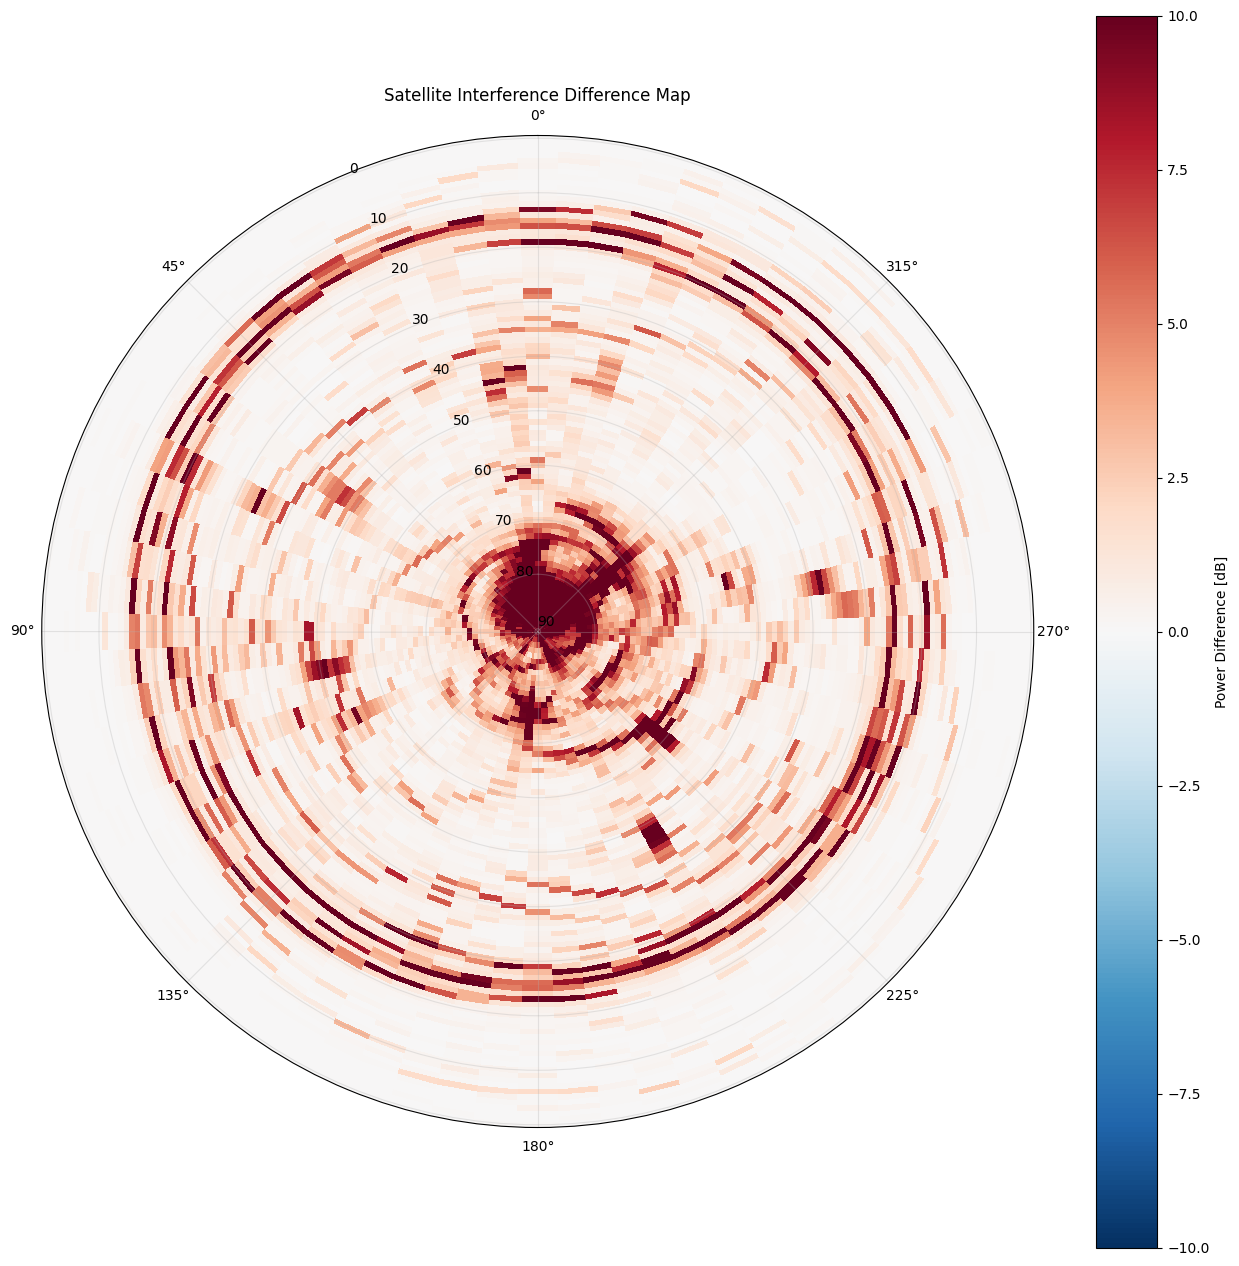

✓ Interference difference map saved as '03_interference_difference_map.png'


In [10]:
print("Step 8: Creating interference difference map...")

# Plot difference map
fig, ax = plot_difference_map(
    map_with_satellites, map_without_satellites,
    azimuth_grid, elevation_grid,
    title="Satellite Interference Difference Map"
)
plt.savefig('03_interference_difference_map.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Interference difference map saved as '03_interference_difference_map.png'")


## Step 9: Analyze Interference Patterns

Let's analyze the interference patterns to understand the spatial distribution of satellite effects.


In [11]:
print("Step 9: Analyzing interference patterns...")

# Convert to power for analysis
power_with_sat = temperature_to_power(map_with_satellites, BANDWIDTH)
power_without_sat = temperature_to_power(map_without_satellites, BANDWIDTH)

# Compute interference statistics
interference_db = 10 * np.log10(power_with_sat) - 10 * np.log10(power_without_sat)

# Find regions with significant interference
significant_interference = interference_db > 5  # 5 dB threshold
num_significant_points = np.sum(significant_interference)
total_points = interference_db.size

print("Interference Analysis:")
print(f"  - Total sky points: {total_points}")
print(f"  - Points with >5 dB interference: {num_significant_points}")
print(f"  - Percentage of sky affected: {100 * num_significant_points / total_points:.1f}%")
print(f"  - Maximum interference: {np.nanmax(interference_db):.1f} dB")
print(f"  - Average interference: {np.nanmean(interference_db):.1f} dB")
print(f"  - Interference standard deviation: {np.nanstd(interference_db):.1f} dB")


Step 9: Analyzing interference patterns...
Interference Analysis:
  - Total sky points: 6552
  - Points with >5 dB interference: 1273
  - Percentage of sky affected: 19.4%
  - Maximum interference: 54.9 dB
  - Average interference: 3.1 dB
  - Interference standard deviation: 5.1 dB


## Step 10: Create Side-by-Side Comparison

Finally, let's create a comprehensive side-by-side comparison of both scenarios for easy visual analysis.


Step 10: Creating side-by-side comparison...
  - Global power range: -140.8 to -85.8 dBW


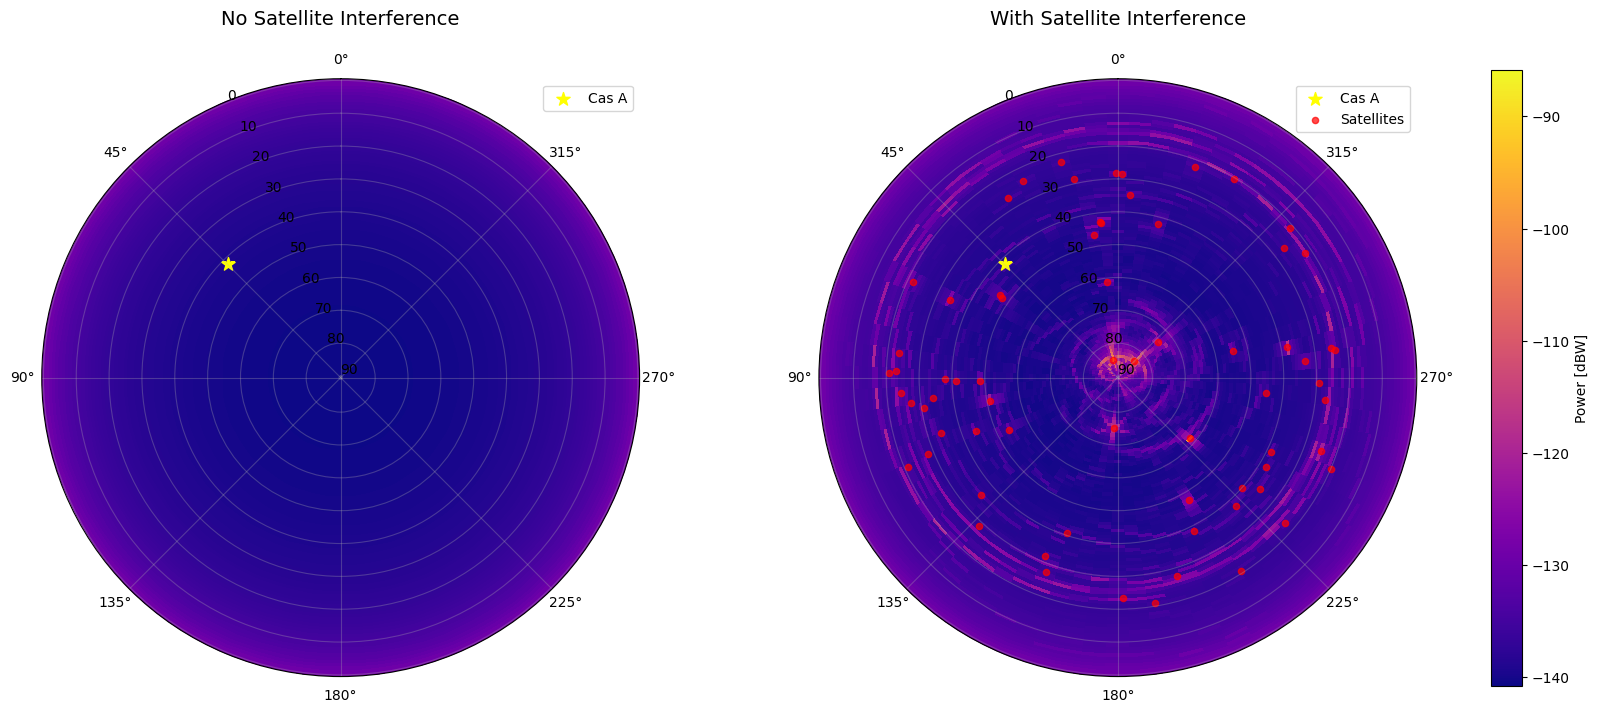

✓ Side-by-side comparison saved as '03_sky_maps_comparison.png'


In [12]:
print("Step 10: Creating side-by-side comparison...")

# Create figure with subplots and extra space for colorbar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), subplot_kw={'projection': 'polar'})

# Convert to power and compute dB values
power_without_db = 10 * np.log10(temperature_to_power(map_without_satellites, BANDWIDTH))
power_with_db = 10 * np.log10(temperature_to_power(map_with_satellites, BANDWIDTH))

# Find global min and max for consistent color scale
global_min = min(np.nanmin(power_without_db), np.nanmin(power_with_db))
global_max = max(np.nanmax(power_without_db), np.nanmax(power_with_db))

print(f"  - Global power range: {global_min:.1f} to {global_max:.1f} dBW")

# Plot without satellites with consistent scale
pc1 = ax1.pcolormesh(np.radians(azimuth_grid), 90 - elevation_grid, power_without_db,
                     cmap="plasma", vmin=global_min, vmax=global_max)
ax1.set_title("No Satellite Interference", fontsize=14, pad=20)
ax1.set_yticks(range(0, 91, 10))
ax1.set_yticklabels([str(x) for x in range(90, -1, -10)])
ax1.set_theta_zero_location("N")

# Add source position
src_pt = source_trajectory.get_traj()[source_trajectory.get_traj()['times'] == time_plot]
if len(src_pt) > 0:
    ax1.scatter(np.radians(src_pt['azimuths']), 90 - src_pt['elevations'],
                marker="*", c="yellow", s=100, label="Cas A")
    ax1.legend()

# Plot with satellites with consistent scale
_ = ax2.pcolormesh(np.radians(azimuth_grid), 90 - elevation_grid, power_with_db,
                   cmap="plasma", vmin=global_min, vmax=global_max)
ax2.set_title("With Satellite Interference", fontsize=14, pad=20)
ax2.set_yticks(range(0, 91, 10))
ax2.set_yticklabels([str(x) for x in range(90, -1, -10)])
ax2.set_theta_zero_location("N")

# Add source and satellite positions
if len(src_pt) > 0:
    ax2.scatter(np.radians(src_pt['azimuths']), 90 - src_pt['elevations'],
                marker="*", c="yellow", s=100, label="Cas A")

# Add satellite positions
sats_at_t = constellation.get_sats_names_at_time(time_plot)
sel_sats = sats_at_t[:len(sats_at_t)]
for s in sel_sats:
    sat = constellation.get_sat_traj(s)
    sat_pt = sat[sat['times'] == time_plot]
    ax2.scatter(np.radians(sat_pt['azimuths']), 90 - sat_pt['elevations'],
                c='red', s=20, alpha=0.7, label='Satellites' if s == sel_sats[0] else "")

ax2.legend()

# Add shared colorbar on the right side of the entire figure
cbar = plt.colorbar(pc1, ax=[ax1, ax2], shrink=0.8, pad=0.02)
cbar.set_label("Power [dBW]")

# Adjust layout to ensure equal subplot sizes and make room for colorbar
plt.subplots_adjust(wspace=0.3, right=0.75)
plt.savefig('03_sky_maps_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Side-by-side comparison saved as '03_sky_maps_comparison.png'")


## Summary

Congratulations! You have successfully completed Tutorial 03.